# Overview of `eolearn.core`

`eolearn.core` is the main subpackage which implements the basic building blocks:

- `EOPatch`,
- `EOTask`,
- `EONode`,
- `EOWorkflow`,
- `EOExecutor`,

and commonly used functionalities.

## EOPatch <a id="EOPatch"></a>

The first basic object in the package is a data container, called `EOPatch`. 

![eopatch](./images/eopatch.png)

- It is designed to store all types of EO data for a single geographical location.
- Typically it is defined by a bounding box and a coordinate reference system.
- There is no limit to how much data a single `EOPatch` can store, but typically it shouldn't be more than the size of your RAM.

EO data can be divided into categories, called "feature types" according to the following properties:

| `FeatureType` | Type of data | Time component |  Spatial component | Type of values | Python object | Shape |
| --- | --- | --- | --- | --- | --- | --- |
| DATA | raster | <span style="color:green">yes</span> | <span style="color:green">yes</span> | float | `numpy.ndarray` | `t x n x m x d` |
| MASK | raster | <span style="color:green">yes</span> | <span style="color:green">yes</span> | integer | `numpy.ndarray` | `t x n x m x d` |
| SCALAR | raster | <span style="color:green">yes</span> | <span style="color:red">no</span> | float | `numpy.ndarray` | `t x d` |
| LABEL | raster | <span style="color:green">yes</span> | <span style="color:red">no</span> | integer | `numpy.ndarray` | `t x d` |
| DATA_TIMELESS | raster | <span style="color:red">no</span> | <span style="color:green">yes</span> | float | `numpy.ndarray` | `n x m x d` |
| MASK_TIMELESS | raster | <span style="color:red">no</span> | <span style="color:green">yes</span> | integer | `numpy.ndarray` | `n x m x d` |
| SCALAR_TIMELESS | raster | <span style="color:red">no</span> | <span style="color:red">no</span> | float | `numpy.ndarray` | `d` |
| LABEL_TIMELESS | raster | <span style="color:red">no</span> | <span style="color:red">no</span> | integer | `numpy.ndarray` | `d` |
| VECTOR | vector | <span style="color:green">yes</span> | <span style="color:green">yes</span> | / | `geopandas.GeoDataFrame` | Required columns `geometry` and `TIMESTAMP` |
| VECTOR_TIMELESS | vector | <span style="color:red">no</span> | <span style="color:green">yes</span> | / | `geopandas.GeoDataFrame` | Required column `geometry` |
| META_INFO | anything | <span style="color:red">no</span> | <span style="color:red">no</span> | anything | anything | anything |
| TIMESTAMP | timestamps | <span style="color:green">yes</span> | <span style="color:red">no</span> | datetime | `list(datetime.datetime)` | `t` |
| BBOX | bounding box and CRS | <span style="color:red">no</span> | <span style="color:green">yes</span> | coordinates | `sentinelhub.BBox` | / |

Note: `t` specifies time component, `n` and `m` are spatial components (height and width), and `d` is an additional component for data with multiple channels.

Let's start by loading an existing `EOPatch` and displaying it's content (i.e. features):

In [1]:
import os

from eolearn.core import EOPatch

INPUT_FOLDER = os.path.join("..", "..", "example_data")
INPUT_EOPATCH = os.path.join(INPUT_FOLDER, "TestEOPatch")

eopatch = EOPatch.load(
    INPUT_EOPATCH, lazy_loading=False  # Set this parameter to True to load data in memory only when first needed
)

eopatch

EOPatch(
  data={
    BANDS-S2-L1C: numpy.ndarray(shape=(68, 101, 100, 13), dtype=float32)
    CLP: numpy.ndarray(shape=(68, 101, 100, 1), dtype=float32)
    CLP_MULTI: numpy.ndarray(shape=(68, 101, 100, 1), dtype=float32)
    CLP_S2C: numpy.ndarray(shape=(68, 101, 100, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(68, 101, 100, 1), dtype=float32)
    REFERENCE_SCENES: numpy.ndarray(shape=(5, 101, 100, 13), dtype=float32)
  }
  mask={
    CLM: numpy.ndarray(shape=(68, 101, 100, 1), dtype=uint8)
    CLM_INTERSSIM: numpy.ndarray(shape=(68, 101, 100, 1), dtype=bool)
    CLM_MULTI: numpy.ndarray(shape=(68, 101, 100, 1), dtype=bool)
    CLM_S2C: numpy.ndarray(shape=(68, 101, 100, 1), dtype=bool)
    IS_DATA: numpy.ndarray(shape=(68, 101, 100, 1), dtype=uint8)
    IS_VALID: numpy.ndarray(shape=(68, 101, 100, 1), dtype=bool)
  }
  scalar={
    CLOUD_COVERAGE: numpy.ndarray(shape=(68, 1), dtype=float16)
  }
  label={
    IS_CLOUDLESS: numpy.ndarray(shape=(68, 1), dtype=bool)
    RANDOM_DIG

There are multiple ways how to access a feature in the `EOPatch`.

In [2]:
from eolearn.core import FeatureType

# All of these access the same feature:
bands = eopatch.data["BANDS-S2-L1C"]
# or
bands = eopatch[FeatureType.DATA]["BANDS-S2-L1C"]
# or
bands = eopatch[(FeatureType.DATA, "BANDS-S2-L1C")]
# or
bands = eopatch[FeatureType.DATA, "BANDS-S2-L1C"]

type(bands), bands.shape

(numpy.ndarray, (68, 101, 100, 13))

Vector features are handled by `geopandas`:

In [3]:
eopatch[FeatureType.VECTOR, "CLM_VECTOR"].head()

,TIMESTAMP,VALUE,geometry
0,2015-07-31 10:00:09,1.0,"POLYGON ((465181.052 5080254.633, 465181.052 5..."
1,2015-08-20 10:07:28,1.0,"POLYGON ((465181.052 5080254.633, 465181.052 5..."
2,2015-09-19 10:05:43,1.0,"POLYGON ((465181.052 5080254.633, 465181.052 5..."
3,2015-09-29 10:06:33,1.0,"POLYGON ((465181.052 5080254.633, 465181.052 5..."
4,2015-12-08 10:04:09,1.0,"POLYGON ((465181.052 5080254.633, 465181.052 5..."


Special features are bounding box and timestamps:

[datetime.datetime(2015, 7, 11, 10, 0, 8), datetime.datetime(2015, 7, 31, 10, 0, 9), datetime.datetime(2015, 8, 20, 10, 7, 28), datetime.datetime(2015, 8, 30, 10, 5, 47), datetime.datetime(2015, 9, 9, 10, 0, 17)]
BBox(((465181.0522318204, 5079244.8912012065), (466180.53145382757, 5080254.63349641)), crs=CRS('32633'))


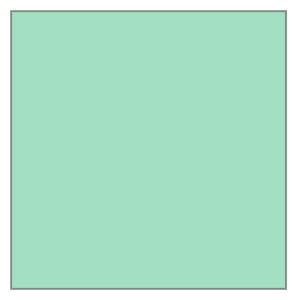

In [4]:
print(eopatch.timestamps[:5])
print(repr(eopatch.bbox))

eopatch.bbox.geometry  # draws the shape of BBox

A list of all features in an `EOPatch` can be obtained with:

In [5]:
eopatch.get_features()

[(<FeatureType.DATA: 'data'>, 'REFERENCE_SCENES'),
 (<FeatureType.DATA: 'data'>, 'CLP_S2C'),
 (<FeatureType.DATA: 'data'>, 'CLP'),
 (<FeatureType.DATA: 'data'>, 'NDVI'),
 (<FeatureType.DATA: 'data'>, 'BANDS-S2-L1C'),
 (<FeatureType.DATA: 'data'>, 'CLP_MULTI'),
 (<FeatureType.MASK: 'mask'>, 'CLM'),
 (<FeatureType.MASK: 'mask'>, 'IS_DATA'),
 (<FeatureType.MASK: 'mask'>, 'CLM_MULTI'),
 (<FeatureType.MASK: 'mask'>, 'CLM_INTERSSIM'),
 (<FeatureType.MASK: 'mask'>, 'IS_VALID'),
 (<FeatureType.MASK: 'mask'>, 'CLM_S2C'),
 (<FeatureType.SCALAR: 'scalar'>, 'CLOUD_COVERAGE'),
 (<FeatureType.LABEL: 'label'>, 'IS_CLOUDLESS'),
 (<FeatureType.LABEL: 'label'>, 'RANDOM_DIGIT'),
 (<FeatureType.VECTOR: 'vector'>, 'CLM_VECTOR'),
 (<FeatureType.DATA_TIMELESS: 'data_timeless'>, 'DEM'),
 (<FeatureType.DATA_TIMELESS: 'data_timeless'>, 'MAX_NDVI'),
 (<FeatureType.MASK_TIMELESS: 'mask_timeless'>, 'RANDOM_UINT8'),
 (<FeatureType.MASK_TIMELESS: 'mask_timeless'>, 'LULC'),
 (<FeatureType.MASK_TIMELESS: 'mask_timeles

Let's create a new `EOPatch` and store some features inside.

In [6]:
import numpy as np

from sentinelhub import CRS, BBox

# Since EOPatch represents geolocated data, it should always have a bounding box
new_eopatch = EOPatch(bbox=BBox((0, 0, 1, 1), CRS.WGS84))

new_eopatch[FeatureType.DATA, "BANDS"] = eopatch[FeatureType.DATA, "BANDS-S2-L1C"]

new_eopatch[FeatureType.MASK_TIMELESS, "NEW_MASK"] = np.zeros((10, 10, 13), dtype=np.uint8)

# The following wouldn't work as there are restrictions to what kind of data can be stored in each feature type
# new_eopatch[FeatureType.MASK, 'NEW_MASK'] = np.zeros((10, 10, 13), dtype=np.uint8)
# new_eopatch[FeatureType.VECTOR, 'NEW_MASK'] = np.zeros((10, 10, 13), dtype=np.uint8)

new_eopatch

EOPatch(
  data={
    BANDS: numpy.ndarray(shape=(68, 101, 100, 13), dtype=float32)
  }
  mask_timeless={
    NEW_MASK: numpy.ndarray(shape=(10, 10, 13), dtype=uint8)
  }
  bbox=BBox(((0.0, 0.0), (1.0, 1.0)), crs=CRS('4326'))
)

It is also possible to delete a feature:

In [7]:
del new_eopatch[FeatureType.DATA, "BANDS"]

new_eopatch

EOPatch(
  mask_timeless={
    NEW_MASK: numpy.ndarray(shape=(10, 10, 13), dtype=uint8)
  }
  bbox=BBox(((0.0, 0.0), (1.0, 1.0)), crs=CRS('4326'))
)

We can save `EOPatch` into a local folder. In case an `EOPatch`  already exists in the specified location, we have to allow to overwrite its features.

In [8]:
from eolearn.core import OverwritePermission

OUTPUT_FOLDER = os.path.join(".", "outputs")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

NEW_EOPATCH_PATH = os.path.join(OUTPUT_FOLDER, "NewEOPatch")

new_eopatch.save(NEW_EOPATCH_PATH, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

Let's load the saved version and compare it with original:

In [9]:
loaded_eopatch = EOPatch.load(NEW_EOPATCH_PATH)

new_eopatch == loaded_eopatch

True

Each `EOPatch` can be shallow or deep copied:

In [10]:
new_eopatch.copy()
new_eopatch.copy(deep=True)

EOPatch(
  mask_timeless={
    NEW_MASK: numpy.ndarray(shape=(10, 10, 13), dtype=uint8)
  }
  bbox=BBox(((0.0, 0.0), (1.0, 1.0)), crs=CRS('4326'))
)

## EOTask <a id="EOTask"></a>

The next core object is `EOTask`, which is a single well-defined operation on one or more `EOPatch` objects.

We can create a new EOTask by creating a class that inherits from the abstract `EOTask` class:

```Python
class FooTask(EOTask):
    
    def __init__(self, foo_param):
        """ Task-specific parameters
        """
        self.foo_param = foo_param
        
    def execute(self, eopatch, *, patch_specific_param):
        
        # Do what foo does on EOPatch and return it
    
        return eopatch
```

- In the initialization method we define task-specific parameters.
- Each task has to implement the `execute` method.
- `execute` method has to be defined in a way that:
    * positional arguments have to be instances of `EOPatch`,
    * other types of arguments should be keyword arguments.
- Otherwise the task itself can do anything.

Example of a task that adds a new feature to existing `EOPatch`:

In [11]:
from typing import Any, Tuple

from eolearn.core import EOTask


class AddFeatureTask(EOTask):
    """Adds a feature to the given EOPatch.

    :param feature: Feature to be added
    :type feature: (FeatureType, feature_name) or FeatureType
    """

    def __init__(self, feature: Tuple[FeatureType, str]):
        self.feature = feature

    def execute(self, eopatch: EOPatch, *, data: Any) -> EOPatch:
        """Returns the EOPatch with added features.

        :param eopatch: input EOPatch
        :param data: data to be added to the feature
        :return: input EOPatch with the specified feature
        """
        eopatch[self.feature] = data

        return eopatch

Let's see how such a task could be used.

In [12]:
eopatch = EOPatch(bbox=BBox((0, 0, 1, 1), CRS.WGS84))

add_feature_task = AddFeatureTask((FeatureType.DATA, "NEW_BANDS"))

data = np.zeros((5, 100, 100, 13))

eopatch = add_feature_task.execute(eopatch, data=data)

eopatch

EOPatch(
  data={
    NEW_BANDS: numpy.ndarray(shape=(5, 100, 100, 13), dtype=float64)
  }
  bbox=BBox(((0.0, 0.0), (1.0, 1.0)), crs=CRS('4326'))
)

The majority of `eo-learn` consists of different EOTasks implementing different operations on EO data.

The list of all EOTasks is available in the [documentation](https://eo-learn.readthedocs.io/en/latest/eotasks.html).

## EONode and EOWorkflow <a id="EONode-and-EOWorkflow"></a>

EOTasks can be joined together into an acyclic processing graph called `EOWorkflow`. Since `eo-learn` `1.0` these tasks first have to be wrapped into instances of `EONode` class.

Here is a simple example of how an `EOWorkflow` can be created:

In [13]:
from eolearn.core import EONode, EOWorkflow, LoadTask, SaveTask

new_feature = FeatureType.LABEL, "NEW_LABEL"

load_task = LoadTask(path=INPUT_FOLDER)
add_feature_task = AddFeatureTask(new_feature)
save_task = SaveTask(path=OUTPUT_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

# Each EONode object defines dependecies to other EONode objects:
load_node = EONode(load_task, inputs=[], name="Load EOPatch")
add_feature_node = EONode(add_feature_task, inputs=[load_node], name="Add a new feature")
save_node = EONode(save_task, inputs=[add_feature_node], name="Save EOPatch")

workflow = EOWorkflow([load_node, add_feature_node, save_node])
# or
workflow = EOWorkflow.from_endnodes(save_node)

# Alternatively, a linear workflow could also be built with a helper function:
# from eolearn.core import linearly_connect_tasks
# nodes = linearly_connect_tasks(load_task, add_feature_task, save_task)
# workflow = EOWorkflow(nodes)

Let's display the dependency graph:

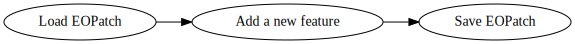

In [14]:
%matplotlib inline

workflow.dependency_graph()

`EOWorkflow` is executed by specifying `EOPatch`-related parameters:

In [15]:
results = workflow.execute(
    {
        load_node: {"eopatch_folder": "TestEOPatch"},
        add_feature_node: {"data": np.zeros((10, 3), dtype=np.uint8)},
        save_node: {"eopatch_folder": "WorkflowEOPatch"},
    }
)

results

WorkflowResults(outputs={}, start_time=datetime.datetime(2023, 3, 8, 9, 4, 40, 324680), end_time=datetime.datetime(2023, 3, 8, 9, 4, 40, 605534), stats={'LoadTask-db6d5a07bd8711edb8fc-d53c2b78843b': NodeStats(node_uid='LoadTask-db6d5a07bd8711edb8fc-d53c2b78843b', node_name='Load EOPatch', start_time=datetime.datetime(2023, 3, 8, 9, 4, 40, 324741), end_time=datetime.datetime(2023, 3, 8, 9, 4, 40, 417614), exception=None, exception_traceback=None), 'AddFeatureTask-db6d5e41bd8711ed8233-a4d329d818d3': NodeStats(node_uid='AddFeatureTask-db6d5e41bd8711ed8233-a4d329d818d3', node_name='Add a new feature', start_time=datetime.datetime(2023, 3, 8, 9, 4, 40, 419545), end_time=datetime.datetime(2023, 3, 8, 9, 4, 40, 419576), exception=None, exception_traceback=None), 'SaveTask-db6d6164bd8711edbfb9-d491c006650a': NodeStats(node_uid='SaveTask-db6d6164bd8711edbfb9-d491c006650a', node_name='Save EOPatch', start_time=datetime.datetime(2023, 3, 8, 9, 4, 40, 420848), end_time=datetime.datetime(2023, 3, 8

A result of a workflow execution is a `WorkflowResults` object. It contains information about times of each node execution and information about potential errors.

<div class="alert alert-info">

**Note:**
    
A difference between executing tasks directly and executing tasks in a workflow is that in a workflow each `EOPatch` input object will be first shallow-copied before being passed to any task.
</div>

## EOExecutor <a id="EOExecutor"></a>

`EOExecutor` handles the execution and monitoring of EOWorkflows. It enables executing a workflow multiple times and in parallel. At the end, it generates a report containing the summary of the workflow's execution process.

Execute previously defined workflow with different arguments.

In [16]:
from eolearn.core import EOExecutor

execution_args = [  # EOWorkflow will be executed for each of these 5 dictionaries:
    {
        load_node: {"eopatch_folder": "TutorialEOPatch"},
        add_feature_node: {"data": idx * np.ones((10, 3), dtype=np.uint8)},
        save_node: {"eopatch_folder": f"ResultEOPatch{idx}"},
    }
    for idx in range(5)
]

executor = EOExecutor(workflow, execution_args, save_logs=True, logs_folder=OUTPUT_FOLDER)

results = executor.run(workers=3)  # The execution will use at most 3 parallel processes

100%|██████████| 5/5 [00:00<00:00, 510.50it/s]


Make the report:

In [17]:
executor.make_report()

print(f"Report was saved to location: {executor.get_report_path()}")

Report was saved to location: /home/ubuntu/Sinergise/eo-learn/examples/core/outputs/eoexecution-report-2022_02_09-12_38_30/report.html
